In [1]:

from example import process_dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import RobustScaler



from rul_gcd.dataset.lives_dataset import AbstractLivesDataset
from rul_gcd.iterators.iterators import LifeDatasetIterator
from rul_gcd.transformation.transformers import Transformer, transformation_pipeline
from rul_gcd.transformation.outliers import IQROutlierRemover, ZScoreOutlierRemover
from rul_gcd.transformation.imputers import NaNRemovalImputer, RollingMedianImputer, RollingMeanImputer, ForwardFillImputer
from rul_gcd.transformation.resamplers import ResamplerTransformer
from rul_gcd.iterators.iterators import WindowedDatasetIterator, LifeDatasetIterator
from rul_gcd.iterators.batcher import get_batcher

# 1. Dataset

In [2]:
class Dataset(AbstractLivesDataset):
    def __init__(self):
        self.lives = [g for _, g in process_dataset().groupby('unit_number')]

    def __getitem__(self, i):
        """

        Returns
        -------
        pd.DataFrame
            DataFrame with the data of the life i
        """
        return self.lives[i]

    @property
    def nlives(self):
        return len(self.lives)

    def __len__(self):
        return len(self.lives)

    def toPandas(self, proportion=1.0):
        return pd.concat(self.lives)

In [3]:
train_dataset = Dataset()


# 2. Transformers

The transformer class receives 4 parameter:
* The target feature name
* The time feature name
* A pipeline to transform the features
* A pipeline to transform the target

The function transformation_pipeline generates a standard pipeline with steps for outlier removal, missing value imputing, data scaling and resampling.

In [4]:
transformer = Transformer('RUL', 
                  'time_in_cycles',
                  transformerX=transformation_pipeline(
                    outlier=IQROutlierRemover(1.5, 1), 
                    imputer=ForwardFillImputer(),
                    scaler=RobustScaler(),
                    resampler=None))

## Iterators

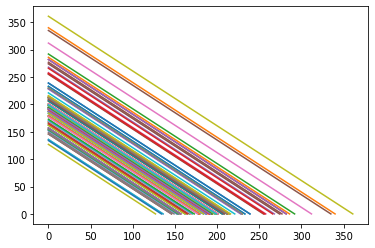

In [6]:
fig, ax = plt.subplots()
it = LifeDatasetIterator(train_dataset, transformer)
for i, (X,y) in enumerate(it):
    ax.plot(y)

## Batcher

The batcher class will return the 

In [11]:
transformer = Transformer('RUL', 
                  'time_in_cycles',
                  transformerX=transformation_pipeline(
                    outlier=IQROutlierRemover(1.5, 1), 
                    imputer=ForwardFillImputer(),
                    scaler=RobustScaler(),
                    resampler=None))
transformer.fit(train_dataset)
window = 25
batch_size = 66
step = 2
train_batcher = get_batcher(train_dataset,  window, batch_size, 
                            transformer, step, shuffle=False)
X, y = next(train_batcher)

### How dos a sample looks like?

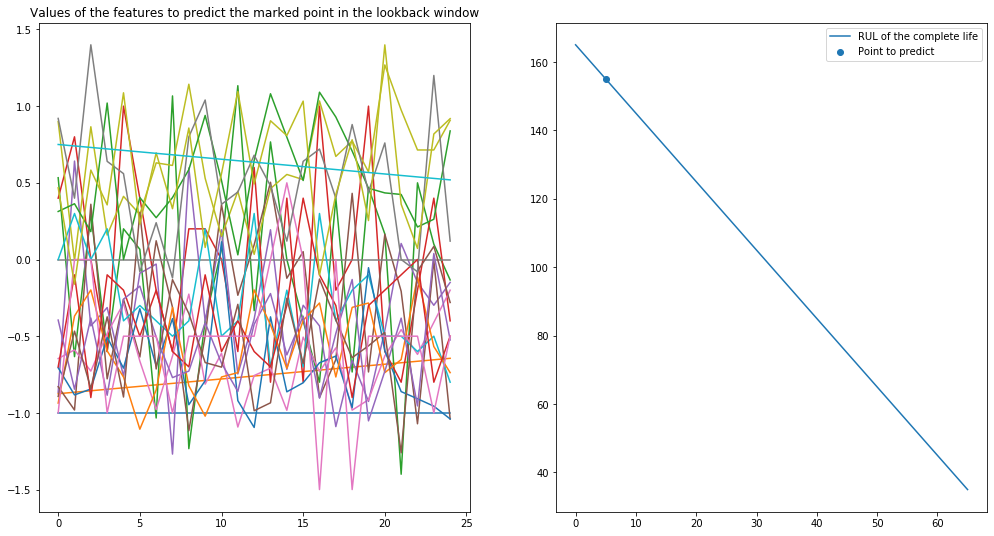

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[5, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(y, label='RUL of the complete life')
ax[1].scatter(x=5, y=y[5], label='Point to predict')
ax[1].legend()

# Model

Let's create a simple model in keras with a same dense layers. The TrainableModel creates the batchers for the trainign and validation set and fit the models.

In [ ]:
class FCN(TrainableModel):
    def __init__(self, layers, dropout, l2, window, batch_size, step, transformer, shuffle, patience=7):
        super(FCN, self).__init__(window, batch_size, step, transformer, shuffle, '.', patience=patience)        
        self.layers_ = []
        self.layers_sizes_ = layers
        self.dropout = dropout
        self.l2 = l2
        self.layers_.append(Flatten())
        for l in self.layers_sizes_:
            self.layers_.append(Dense(l, 
                                      activation='relu',
                                      kernel_regularizer=regularizers.l2(self.l2)))
            self.layers_.append(Dropout(self.dropout))
            self.layers_.append(BatchNormalization())
            
        self.output_ = Dense(1, activation='relu')

    @property
    def name(self):
        return 'FCN'
    
    def parameters(self):
        params = super().parameters()
        params.update({
            'dropout': self.dropout,
            'l2': self.l2,
            'layers': self.layers_sizes_
        })
        return params
        
    def call(self, input):
        x = input
        for l in self.layers_:
            x = l(x)
        return self.output_(x)

In [ ]:
tf.keras.backend.clear_session()
model = FCN([100, 100, 100, 100],
            dropout=0.2,
            l2=0.2,
            window=200,
            batch_size = 16,
            step = 25,
            transformer = Transformer(
                'RUL', 
                'time_in_cycles',
                transformerX=transformation_pipeline(
                    outlier=IQROutlierRemover(1.5, 1), 
                    imputer=ForwardFillImputer(),
                    scaler=RobustScaler(),
                    resampler=None)
            ),
            shuffle=shuffle,
           patience=7)

model.transformer.fit(train_dataset)
model.compile(loss='mse', optimizer=optimizers.SGD(lr=0.001, nesterov=True))
r = model.fit(train_dataset, validation_dataset , epochs=50, verbose=0)